# Bayesian Network Training (Binary Dataset)

This notebook builds and trains a Bayesian network for disease prediction using the binary-formatted dataset.

## Dataset Format
- **prognosis**: Disease name
- **131 symptom columns**: Binary (0=absent, 1=present)

## Network Structure
We use a **Naive Bayes structure**:
- Disease (prognosis) is the parent node
- All symptoms are children of the disease node
- Assumes conditional independence of symptoms given the disease

## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 2. Load Binary Dataset

In [4]:
# Load binary datasets
df_train = pd.read_csv('../data/Training_binary.csv')
df_test = pd.read_csv('../data/Testing_binary.csv')

print(f"Training data: {df_train.shape}")
print(f"Testing data: {df_test.shape}")

# Get symptom columns (all columns except 'prognosis')
symptom_cols = [col for col in df_train.columns if col != 'prognosis']
print(f"\nSymptoms: {len(symptom_cols)}")
print(f"Diseases: {df_train['prognosis'].nunique()}")

# Display sample
print("\nSample data:")
print(df_train.head())

Training data: (4428, 132)
Testing data: (492, 132)

Symptoms: 131
Diseases: 41

Sample data:
                      prognosis  abdominal_pain  abnormal_menstruation  \
0                Hypothyroidism               0                      1   
1                       Malaria               0                      0   
2  Dimorphic hemmorhoids(piles)               0                      0   
3           Peptic ulcer diseae               1                      0   
4              Bronchial Asthma               0                      0   

   acidity  acute_liver_failure  altered_sensorium  anxiety  back_pain  \
0        0                    0                  0        0          0   
1        0                    0                  0        0          0   
2        0                    0                  0        0          0   
3        0                    0                  0        0          0   
4        0                    0                  0        0          0   

   belly_pain  b

## 3. Build Bayesian Network Structure

In [5]:
# Create Naive Bayes structure: prognosis -> All Symptoms
edges = [('prognosis', symptom) for symptom in symptom_cols]

print(f"Creating Bayesian Network with {len(edges)} edges...")
print(f"Structure: Disease (1 node) -> Symptoms ({len(symptom_cols)} nodes)")

# Initialize Discrete Bayesian Network
model = DiscreteBayesianNetwork(edges)

print("\n✓ Bayesian Network structure created!")
print(f"  Nodes: {len(model.nodes())}")
print(f"  Edges: {len(model.edges())}")

Creating Bayesian Network with 131 edges...
Structure: Disease (1 node) -> Symptoms (131 nodes)

✓ Bayesian Network structure created!
  Nodes: 132
  Edges: 131


## 4. Visualize Network Structure

Note: Due to 131 symptoms, we'll show a simplified visualization with just a few symptoms

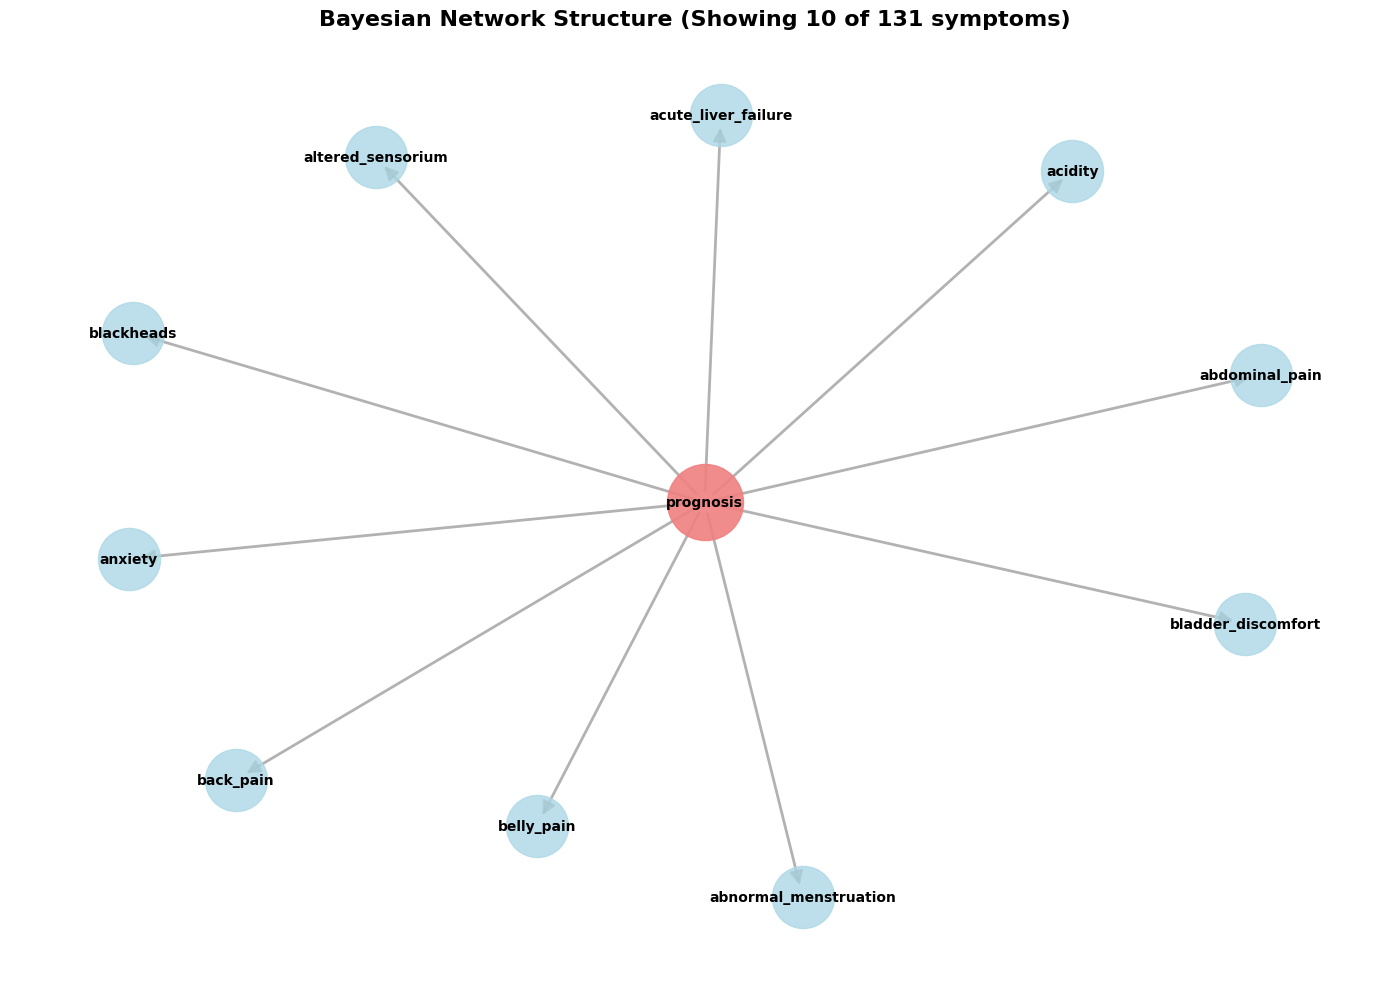

Note: Full network has 131 symptom nodes connected to 'prognosis'


In [6]:
import networkx as nx

# Create a simplified network for visualization (first 10 symptoms only)
sample_symptoms = symptom_cols[:10]
sample_edges = [('prognosis', symptom) for symptom in sample_symptoms]

# Create graph
G = nx.DiGraph()
G.add_edges_from(sample_edges)

# Visualize
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=2, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=['prognosis'], 
                       node_color='lightcoral', node_size=3000, alpha=0.9)
nx.draw_networkx_nodes(G, pos, nodelist=sample_symptoms, 
                       node_color='lightblue', node_size=2000, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                       arrowsize=20, width=2, alpha=0.6)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title(f"Bayesian Network Structure (Showing 10 of {len(symptom_cols)} symptoms)", 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Note: Full network has {len(symptom_cols)} symptom nodes connected to 'prognosis'")

## 5. Learn Parameters (CPTs)

In [7]:
# Prepare data for pgmpy
print("Preparing data for training...")

# Convert prognosis to categorical type
df_train_prepared = df_train.copy()
df_test_prepared = df_test.copy()

df_train_prepared['prognosis'] = df_train_prepared['prognosis'].astype('category')
df_test_prepared['prognosis'] = df_test_prepared['prognosis'].astype('category')

# Ensure all symptom columns are integers
for col in symptom_cols:
    df_train_prepared[col] = df_train_prepared[col].astype(int)
    df_test_prepared[col] = df_test_prepared[col].astype(int)

print("✓ Data types prepared")
print(f"  prognosis: {df_train_prepared['prognosis'].dtype}")
print(f"  symptoms: int64 (binary 0/1)")

# Fit the model using Maximum Likelihood Estimation
print("\nTraining Bayesian Network...")
print("Learning Conditional Probability Tables (CPTs)...\n")

model.fit(df_train_prepared, estimator=MaximumLikelihoodEstimator)

print("✓ Training complete!")
print(f"\nLearned CPTs for {len(model.get_cpds())} variables")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'prognosis': 'C', 'abdominal_pain': 'N', 'abnormal_menstruation': 'N', 'acidity': 'N', 'acute_liver_failure': 'N', 'altered_sensorium': 'N', 'anxiety': 'N', 'back_pain': 'N', 'belly_pain': 'N', 'blackheads': 'N', 'bladder_discomfort': 'N', 'blister': 'N', 'blood_in_sputum': 'N', 'bloody_stool': 'N', 'blurred_and_distorted_vision': 'N', 'breathlessness': 'N', 'brittle_nails': 'N', 'bruising': 'N', 'burning_micturition': 'N', 'chest_pain': 'N', 'chills': 'N', 'cold_hands_and_feets': 'N', 'coma': 'N', 'congestion': 'N', 'constipation': 'N', 'continuous_feel_of_urine': 'N', 'continuous_sneezing': 'N', 'cough': 'N', 'cramps': 'N', 'dark_urine': 'N', 'dehydration': 'N', 'depression': 'N', 'diarrhoea': 'N', 'dischromic _patches': 'N', 'distention_of_abdomen': 'N', 'dizziness': 'N', 'drying_and_tingling_lips': 'N', 'enlarged_thyroid': 'N', 'excessive_hunger': 'N', 'extra_marital_contacts':

Preparing data for training...
✓ Data types prepared
  prognosis: category
  symptoms: int64 (binary 0/1)

Training Bayesian Network...
Learning Conditional Probability Tables (CPTs)...

✓ Training complete!

Learned CPTs for 132 variables


## 6. Display Sample CPTs

In [8]:
# Display disease prior probabilities
print("="*80)
print("DISEASE PRIOR PROBABILITIES")
print("="*80)
disease_cpd = model.get_cpds('prognosis')
print(disease_cpd)
print()

DISEASE PRIOR PROBABILITIES
+----------------------------------------------------+-----------+
| prognosis((vertigo) Paroymsal  Positional Vertigo) | 0.0243902 |
+----------------------------------------------------+-----------+
| prognosis(AIDS)                                    | 0.0243902 |
+----------------------------------------------------+-----------+
| prognosis(Acne)                                    | 0.0243902 |
+----------------------------------------------------+-----------+
| prognosis(Alcoholic hepatitis)                     | 0.0243902 |
+----------------------------------------------------+-----------+
| prognosis(Allergy)                                 | 0.0243902 |
+----------------------------------------------------+-----------+
| prognosis(Arthritis)                               | 0.0243902 |
+----------------------------------------------------+-----------+
| prognosis(Bronchial Asthma)                        | 0.0243902 |
+---------------------------------

In [9]:
# Display CPT for a common symptom
if 'fatigue' in symptom_cols:
    print("="*80)
    print("CPT for 'fatigue' given Disease")
    print("="*80)
    fatigue_cpd = model.get_cpds('fatigue')
    print(fatigue_cpd)
    print("\nInterpretation: Shows P(fatigue=0 or 1 | Disease)")
    print()

CPT for 'fatigue' given Disease
+------------+-----+------------------------+
| prognosis  | ... | prognosis(hepatitis A) |
+------------+-----+------------------------+
| fatigue(0) | ... | 1.0                    |
+------------+-----+------------------------+
| fatigue(1) | ... | 0.0                    |
+------------+-----+------------------------+

Interpretation: Shows P(fatigue=0 or 1 | Disease)



In [10]:
# Display CPT for another symptom
if 'high_fever' in symptom_cols:
    print("="*80)
    print("CPT for 'high_fever' given Disease")
    print("="*80)
    fever_cpd = model.get_cpds('high_fever')
    print(fever_cpd)
    print()

CPT for 'high_fever' given Disease
+---------------+-----+------------------------+
| prognosis     | ... | prognosis(hepatitis A) |
+---------------+-----+------------------------+
| high_fever(0) | ... | 1.0                    |
+---------------+-----+------------------------+
| high_fever(1) | ... | 0.0                    |
+---------------+-----+------------------------+



## 7. Visualize CPT as Heatmap

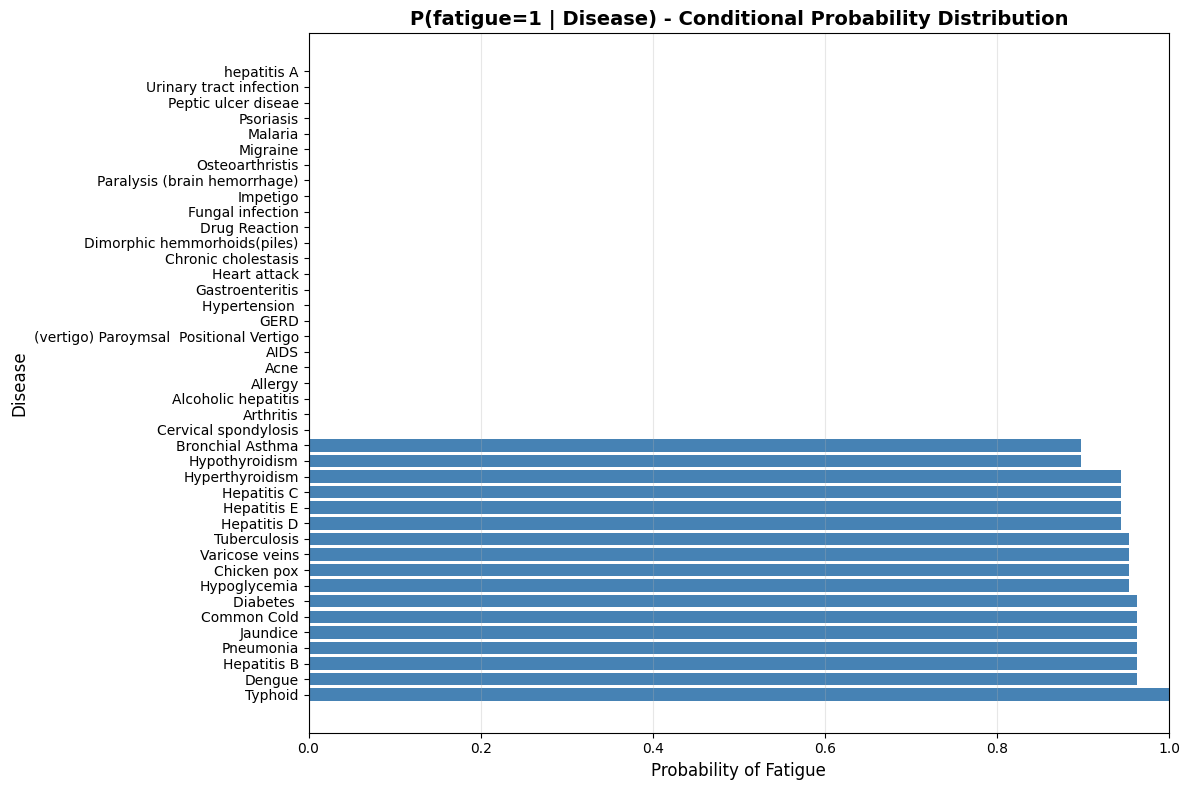

In [11]:
# Create heatmap for a symptom's CPT
if 'fatigue' in symptom_cols:
    fatigue_cpd = model.get_cpds('fatigue')
    
    # Extract probabilities for fatigue=1 (present)
    diseases = fatigue_cpd.state_names['prognosis']
    probs = fatigue_cpd.values[1, :]  # Row 1 = fatigue present
    
    # Create dataframe for plotting
    df_plot = pd.DataFrame({
        'Disease': diseases,
        'P(fatigue=1)': probs
    }).sort_values('P(fatigue=1)', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(df_plot['Disease'], df_plot['P(fatigue=1)'], color='steelblue')
    plt.xlabel('Probability of Fatigue', fontsize=12)
    plt.ylabel('Disease', fontsize=12)
    plt.title('P(fatigue=1 | Disease) - Conditional Probability Distribution', 
              fontsize=14, fontweight='bold')
    plt.xlim(0, 1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 8. Create Inference Engine

In [12]:
# Create inference object
inference = VariableElimination(model)

print("✓ Inference engine created!")
print("  Algorithm: Variable Elimination")

✓ Inference engine created!
  Algorithm: Variable Elimination


## 9. Test Inference with Example

In [13]:
# Test with Diabetes symptoms
evidence = {
    'fatigue': 1,
    'weight_loss': 1,
    'restlessness': 1,
    'lethargy': 1,
    'irregular_sugar_level': 1,
    'blurred_and_distorted_vision': 1,
    'obesity': 1,
    'excessive_hunger': 1,
    'increased_appetite': 1,
    'polyuria': 1
}

print("Testing inference with Diabetes symptoms...")
print(f"Evidence: {list(evidence.keys())}\n")

result = inference.query(variables=['prognosis'], evidence=evidence)

# Get top 5 predictions
probs = result.values
diseases = result.state_names['prognosis']
predictions = sorted(zip(diseases, probs), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 predictions:")
for i, (disease, prob) in enumerate(predictions, 1):
    print(f"{i}. {disease:30s} {prob*100:6.2f}%")

Testing inference with Diabetes symptoms...
Evidence: ['fatigue', 'weight_loss', 'restlessness', 'lethargy', 'irregular_sugar_level', 'blurred_and_distorted_vision', 'obesity', 'excessive_hunger', 'increased_appetite', 'polyuria']

Top 5 predictions:
1. Diabetes                       100.00%
2. (vertigo) Paroymsal  Positional Vertigo   0.00%
3. AIDS                             0.00%
4. Acne                             0.00%
5. Alcoholic hepatitis              0.00%


## 10. Create Prediction Function

In [14]:
def predict_disease(symptoms_dict, top_n=5):
    """
    Predict diseases given symptoms.
    
    Args:
        symptoms_dict: Dictionary of {symptom: 1} for present symptoms
        top_n: Number of top predictions to return
    
    Returns:
        List of tuples (disease, probability)
    """
    if not symptoms_dict:
        return []
    
    # Query the network
    result = inference.query(variables=['prognosis'], evidence=symptoms_dict)
    
    # Extract probabilities
    probs = result.values
    diseases = result.state_names['prognosis']
    
    # Create list of (disease, probability) tuples
    predictions = list(zip(diseases, probs))
    
    # Sort by probability (descending)
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    return predictions[:top_n]

print("✓ Prediction function created!")

✓ Prediction function created!


## 11. Evaluate on Test Set

In [15]:
# Make predictions on test set
y_true = []
y_pred = []
confidence_scores = []

print("Evaluating on test set...\n")

for idx, row in df_test_prepared.iterrows():
    # Get actual disease
    actual_disease = row['prognosis']
    
    # Get symptoms (only those present)
    symptoms = {col: int(row[col]) for col in symptom_cols if row[col] == 1}
    
    # Predict
    if symptoms:  # Only predict if there are symptoms
        predictions = predict_disease(symptoms, top_n=1)
        predicted_disease, confidence = predictions[0]
    else:
        predicted_disease = "Unknown"
        confidence = 0.0
    
    y_true.append(actual_disease)
    y_pred.append(predicted_disease)
    confidence_scores.append(confidence)
    
    if idx < 10:  # Show first 10 samples
        print(f"Sample {idx+1}: Actual={actual_disease:30s} Predicted={predicted_disease:30s} Confidence={confidence*100:6.2f}%")

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
avg_confidence = np.mean(confidence_scores)

print(f"\n{'='*80}")
print(f"Test Set Accuracy: {accuracy*100:.2f}%")
print(f"Average Confidence: {avg_confidence*100:.2f}%")
print(f"{'='*80}")

Evaluating on test set...

Sample 1: Actual=Alcoholic hepatitis            Predicted=Alcoholic hepatitis            Confidence=100.00%
Sample 2: Actual=Pneumonia                      Predicted=Pneumonia                      Confidence=100.00%
Sample 3: Actual=Paralysis (brain hemorrhage)   Predicted=Paralysis (brain hemorrhage)   Confidence=100.00%
Sample 4: Actual=Hepatitis B                    Predicted=Hepatitis B                    Confidence=100.00%
Sample 5: Actual=Gastroenteritis                Predicted=Gastroenteritis                Confidence=100.00%
Sample 6: Actual=Hyperthyroidism                Predicted=Hyperthyroidism                Confidence=100.00%
Sample 7: Actual=Tuberculosis                   Predicted=Tuberculosis                   Confidence=100.00%
Sample 8: Actual=Cervical spondylosis           Predicted=Cervical spondylosis           Confidence=100.00%
Sample 9: Actual=Peptic ulcer diseae            Predicted=Peptic ulcer diseae            Confidence=100.00%
S

## 12. Confidence Score Distribution

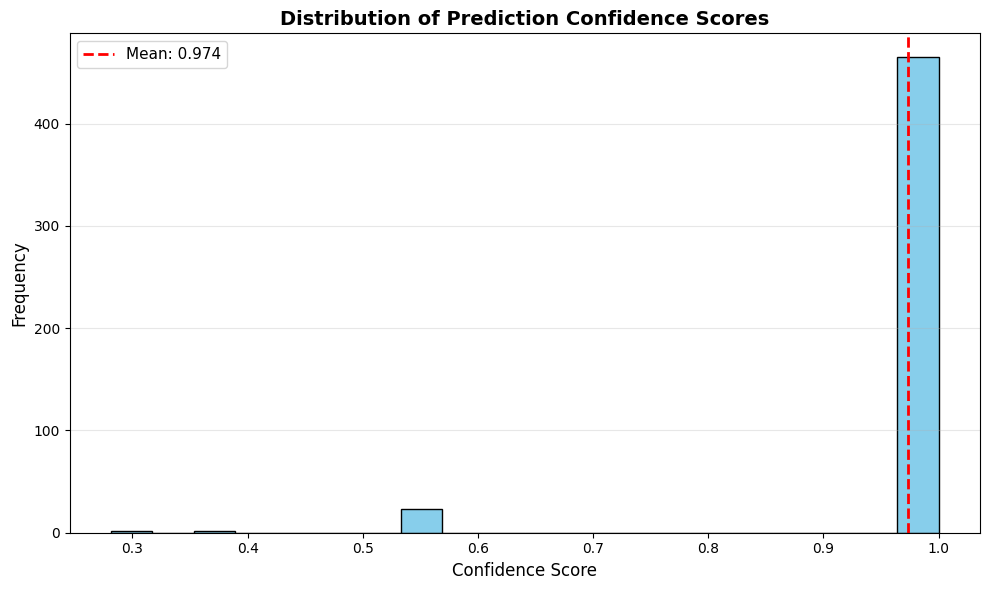

In [16]:
# Plot confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Confidence Scores', fontsize=14, fontweight='bold')
plt.axvline(avg_confidence, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {avg_confidence:.3f}')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Save the Model

In [17]:
# Save the trained model and inference engine
model_data = {
    'model': model,
    'inference': inference,
    'symptom_cols': symptom_cols,
    'diseases': sorted(df_train_prepared['prognosis'].unique()),
    'accuracy': accuracy,
    'avg_confidence': avg_confidence
}

with open('../models/disease_bayesian_network.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✓ Model saved to: ../models/disease_bayesian_network.pkl")
print(f"\nModel Statistics:")
print(f"  - Accuracy: {accuracy*100:.2f}%")
print(f"  - Avg Confidence: {avg_confidence*100:.2f}%")
print(f"  - Diseases: {len(model_data['diseases'])}")
print(f"  - Symptoms: {len(symptom_cols)}")

✓ Model saved to: ../models/disease_bayesian_network.pkl

Model Statistics:
  - Accuracy: 94.51%
  - Avg Confidence: 97.36%
  - Diseases: 41
  - Symptoms: 131


## 14. Model Summary

In [18]:
print("="*80)
print("BAYESIAN NETWORK MODEL SUMMARY")
print("="*80)
print(f"Architecture: Naive Bayes")
print(f"  - Parent node: Disease (prognosis) with {df_train_prepared['prognosis'].nunique()} states")
print(f"  - Child nodes: {len(symptom_cols)} binary symptom nodes")
print(f"  - Total edges: {len(edges)}")
print(f"\nTraining:")
print(f"  - Training samples: {len(df_train):,}")
print(f"  - Testing samples: {len(df_test):,}")
print(f"  - Estimator: Maximum Likelihood")
print(f"\nPerformance:")
print(f"  - Test accuracy: {accuracy*100:.2f}%")
print(f"  - Average confidence: {avg_confidence*100:.2f}%")
print(f"\nInference:")
print(f"  - Algorithm: Variable Elimination")
print(f"  - Output: Probability distribution over {len(model_data['diseases'])} diseases")
print("\n✓ Model ready for deployment!")
print("="*80)

BAYESIAN NETWORK MODEL SUMMARY
Architecture: Naive Bayes
  - Parent node: Disease (prognosis) with 41 states
  - Child nodes: 131 binary symptom nodes
  - Total edges: 131

Training:
  - Training samples: 4,428
  - Testing samples: 492
  - Estimator: Maximum Likelihood

Performance:
  - Test accuracy: 94.51%
  - Average confidence: 97.36%

Inference:
  - Algorithm: Variable Elimination
  - Output: Probability distribution over 41 diseases

✓ Model ready for deployment!
